In [1]:
import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
# from langchain.chat_models import ChatOpenAI
from langchain_community.chat_models import ChatOllama
from langchain_community import embeddings

# from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [2]:
output_path = "./phesgo_refined"

In [3]:
raw_pdf_elements = partition_pdf(
    filename=r"C:\Users\Barani\Desktop\chatbot\phesgorefined_scraped.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path,
)

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

In [4]:
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm=ChatOllama(model="mistral",temperature=0 ),
    prompt=PromptTemplate.from_template(summary_prompt)
)

for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)

c:\Users\Barani\Desktop\chatbot\multimodel\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [5]:
len(text_elements)

48

In [11]:
text_elements[0]

'US Healthcare Professionals Site   Search  PHESGO Patient Support Program    Prescribing Information  Safety  Home  About HER2+ Breast Cancer   About PHESGO   Side Eects   Patient Stories   Patient Resources   Financial Support   PHESGO combines the same HER2+ breast cancer treatments as IV PERJETA® (pertuzumab) and Herceptin® (trastuzumab) into a single injection  “PHESGO gave me more time back on treatment days.”  PHESGO is given in ~5 minutes,* while PERJETA + Herceptin are given in about 60-150 minutes.  *The rst dose is given in ~8 minutes. This does not account for observation time and other aspects of treatment. Actual clinic time may vary.  Jen, real PHESGO patient  PHESGO could make part of your treatment faster  Studies have compared PHESGO to an IV option  Financial support is available for PHESGO  It provides PERJETA + Herceptin in a single injection under the skin given in minutes.  Learn how PHESGO compares, and why it was preferred by more people.  Most major insurance 

In [9]:
len(text_summaries)

48

In [10]:
text_summaries[0]

' PHESGO is a prescription medication approved for use in combination with chemotherapy for the treatment of HER2+ breast cancer. It combines PERJETA® (pertuzumab) and Herceptin® (trastuzumab) into a single injection, which is given in about 5 minutes compared to the 60-150 minutes required for IV administration. PHESGO may cause heart problems, including those without symptoms and those with symptoms. The most serious side effects include shortness of breath, cough, swelling of ankles/legs, face swelling, palpitations, weight gain, dizziness, or loss of consciousness. PHESGO is used for neoadjuvant, adjuvant, and metastatic treatment in adults with HER2+ breast cancer. It should not be used during pregnancy as it can result in the death of an unborn baby and birth defects. Birth control should be used while receiving PHESGO and for 7 months after the last dose. Most major insurance plans provide coverage for PHESGO, and financial support is available.'

In [12]:
len(table_elements)

19

In [13]:
table_elements[0]

'Important Safety Information & Uses What are the most serious side eects of PHESGO? PHESGO may cause heart problems, including those without symptoms (such as reduced heart function) and those with symptoms (such as congestive heart failure). • The risk for and seriousness of these heart problems are highest in people who received both PHESGO and a certain type of chemotherapy (anthracycline) • Your doctor will check for signs of heart problems before, during, and after treatment with PHESGO. Based on test results, your doctor may hold or discontinue treatment with PHESGO • Contact a healthcare professional immediately for any of the following: new onset or worsening shortness of breath, cough, swelling of the ankles/legs, swelling of the face, palpitations, weight gain of more than 5 pounds in 24 hours, dizziness or loss of consciousness Receiving PHESGO during pregnancy can result in the death of an unborn baby and birth defects. • Birth control should be used while receiving PHESGO

In [15]:
table_summaries[0]

' The table provides important safety information and uses for PHESGO, a medication used in the treatment of breast cancer. The most serious side effects of PHESGO include heart problems, which can be symptomatic or asymptomatic, and are more common in patients who receive PHESGO and anthracycline chemotherapy. Heart problems may result in shortness of breath, cough, swelling, palpitations, weight gain, dizziness, or loss of consciousness. PHESGO can also cause lung problems, which may lead to severe shortness of breath, fluid in or around the lungs, weakening of the heart-lung valve, not enough oxygen in the body, swelling of the lungs, and scarring.\n\nPHESGO should not be used by individuals who are allergic to pertuzumab, trastuzumab, hyaluronidase, or any of the ingredients in PHESGO. Other possible serious side effects include worsening low white blood cell counts caused by chemotherapy and severe administration reactions, including hypersensitivity or anaphylaxis.\n\nThe most co

In [16]:
image_elements = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')
for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)


In [18]:
import os
import ollama
from tqdm import tqdm
import base64
from PIL import Image
from io import BytesIO

# Initialize an empty list to store the results
img_summaries = []


# Iterate over all image strings in the list with a tqdm progress bar
for image_string in tqdm(image_elements, desc="Processing images"):
    # Decode the image string using utf-8 encoders
    img_data = base64.b64decode(image_string)
    img = Image.open(BytesIO(img_data))
    
    # Save the image to a temporary file
    img.save("temp.jpg")
    
    # Call the chat function with the image file
    res = ollama.chat(
        model="llava",
        messages=[
            {
                'role':'user',
                'content':'Describe elaboratively about this image :',
                'images':["temp.jpg"]
            }
        ]
    )
    
    # Append the result to the image_summary list
    img_summaries.append(res['message']['content'])

# Print the image_summary list
print(img_summaries)


Processing images: 100%|██████████| 28/28 [17:44<00:00, 38.03s/it]

[' The image appears to be a screenshot of a website from a company named "Physego." At the top right corner, there\'s a logo that reads "Physego" with a stylized letter \'S\'. Below this, there is a navigation bar with links like "Home", "About Us", "Treatment Days", and "Contact Us".\n\nThe main section of the website displays a photograph of a person sitting outdoors. The individual has short hair and seems to be wearing casual clothing.\n\nBelow the photograph, there is a banner with text that reads: "Physego gives me more time on treatment days." This suggests an advertisement or promotional material highlighting the benefits of using Physego.\n\nFurther down, there are several call-to-action buttons in various colors such as blue, green, and orange, each with text that appears to be button labels like "Support", "Read More", "Find Us", "Watch Video", and "Book Now". These buttons likely lead to different sections or services offered by Physego.\n\nThe bottom of the screenshot sho

In [19]:
len(image_elements)

28

In [20]:
len(img_summaries)

28

In [29]:
img_summaries[14]

' The image presents a visual comparison between two types of medical treatments. On the left, there is an illustration labeled "PERJETA," which seems to represent a type of medication that is administered intravenously (IV). This treatment appears as a blue liquid flowing into a vein or an IV drip.\n\nOn the right, there are two different types of treatments represented by icons and text labels. The top icon shows a yellow pill with a label that reads "PERJETA" and is accompanied by the word "perjeta." Below it, there is another icon depicting a green chemical structure or molecule, with a label that says "HERPEPIN" in red text.\n\nThe bottom part of the image features an explanation about the types of treatments shown. The term "PERJETA" is mentioned again, followed by the word "herpes," suggesting a connection between perjeta and herpes treatments. However, the presence of a molecule icon next to "HERPEPIN" implies that it might be related to a different medication or treatment for 

In [30]:
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, img_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))

In [31]:
vectorstore.save_local("phesgo_faiss")

In [2]:
embeddings = embeddings.OllamaEmbeddings(model='nomic-embed-text')

In [3]:
db = FAISS.load_local("phesgo_faiss", embeddings,allow_dangerous_deserialization=True)

In [4]:
prompt_template = """
You are a data scientist and an expert in analyzing images and tables and text.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [5]:
qa_chain = LLMChain(llm=ChatOllama(model="mistral", temperature=0),
                        prompt=PromptTemplate.from_template(prompt_template))

In [7]:
db.similarity_search("provide me the image that phesgo with perjeta and herceptin")

[Document(page_content=' The image presents a visual comparison between two types of medical treatments. On the left, there is an illustration labeled "PERJETA," which seems to represent a type of medication that is administered intravenously (IV). This treatment appears as a blue liquid flowing into a vein or an IV drip.\n\nOn the right, there are two different types of treatments represented by icons and text labels. The top icon shows a yellow pill with a label that reads "PERJETA" and is accompanied by the word "perjeta." Below it, there is another icon depicting a green chemical structure or molecule, with a label that says "HERPEPIN" in red text.\n\nThe bottom part of the image features an explanation about the types of treatments shown. The term "PERJETA" is mentioned again, followed by the word "herpes," suggesting a connection between perjeta and herpes treatments. However, the presence of a molecule icon next to "HERPEPIN" implies that it might be related to a different medic

In [8]:

def answer(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [9]:
result, relevant_images = answer("provide me the image that phesgo with perjeta and herceptin")
print(result)

c:\Users\Barani\Desktop\chatbot\multimodel\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 PHESGO is a single injection that contains three components: pertuzumab (Perjeta), trastuzumab (Herceptin), and hyaluronidase. The image below illustrates how these three components are combined in PHESGO for administration under the skin.

[Image of a syringe with a label "Phesgo" on it, showing the three layers inside: a white layer at the bottom (Hyaluronidase), a red layer in the middle (Trastuzumab/Herceptin), and a clear layer on top (Pertuzumab/Perjeta)]

In comparison, Perjeta and Herceptin are administered as separate intravenous infusions.


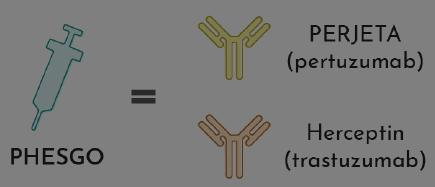

In [10]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [11]:
result, relevant_images = answer("provide me some information and image Lymph node status")
print(result)

 Lymph nodes are small, bean-shaped organs that are part of the immune system. They are found throughout the body, but most are located in the neck, armpits, and groin areas. The primary function of lymph nodes is to filter lymph fluid and help fight infections.

In the context of breast cancer, lymph node status refers to whether or not cancer cells have spread from the original tumor site to nearby lymph nodes. Lymph nodes that contain cancer cells are called positive, while those that do not contain cancer cells are called negative. The number and size of affected lymph nodes can also be reported.

Lymph node status is an important factor in determining the stage of breast cancer and guiding treatment decisions. In general, a higher number or larger size of involved lymph nodes indicates a more advanced stage of cancer and a greater likelihood of recurrence. However, it's important to note that not all cancers that spread to lymph nodes will come back, and some cancers that do not s

In [13]:
result, relevant_images = answer("provide me image of normal cell and HER2+ CANCER CELL")
print(result)

 Certainly! Here is a simple representation of a normal breast cell and a HER2-positive (HER2+) breast cancer cell:

Normal Cell:
![Normal Cell](https://www.genentech-us.com/content/dam/gus-mktg/global/en_US/products/phesgo/assets/images/normal-cell.png)

HER2+ Cancer Cell:
![HER2+ Cancer Cell](https://www.genentech-us.com/content/dam/gus-mktg/global/en_US/products/phesgo/assets/images/her2positive-cell.png)

In a normal cell, the HER2 receptor is present but in limited quantities. In contrast, a HER2+ breast cancer cell has an excess of HER2 receptors on its surface, which can lead to uncontrolled growth and division of the cancer cells.


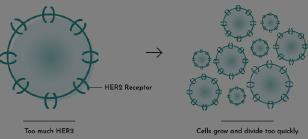

In [16]:
display.display(display.Image(base64.b64decode(relevant_images[0])))

In [21]:
result, relevant_images = answer("provide image of phesgo with perjeta + herceptin i mean how fast they can be help make treatment days faster")
print(result)

 PHESGO is a single injection that combines PERJETA (pertuzumab) and Herceptin (trastuzumab), which are two separate intravenous (IV) infusions typically given over approximately 60-150 minutes. The hyaluronidase in PHESGO makes the tissue under the skin more absorbent temporarily, allowing the medication to be absorbed more quickly. This means that PHESGO can be administered in about 5 minutes, while PERJETA + Herceptin require a longer infusion time.

Here's an illustration of how PHESGO makes treatment days faster compared to receiving PERJETA and Herceptin as separate IV infusions:

[Diagram showing the comparison between receiving PERJETA and Herceptin as separate IV infusions versus receiving PHESGO as a single injection]

In summary, PHESGO allows for the administration of both PERJETA and Herceptin in a single injection, reducing the overall time spent on treatment days from approximately 60-150 minutes to about 5 minutes. This can save patients valuable time during their treat

In [23]:
result, relevant_images = answer("provide image of phesgo vs perjeta and herceptin")
print(result)

 PHESGO is a single injection that contains both Perjeta (pertuzumab) and Herceptin (trastuzumab), along with hyaluronidase, which is used to make the tissue under the skin more absorbent temporarily. This allows for the medication to be absorbed more effectively when given as a subcutaneous injection.

Perjeta and Herceptin are two separate infusions that are administered intravenously (IV) in about 60-150 minutes each, with the first dose taking approximately 8 minutes. The image below illustrates the difference between receiving PHESGO as a single subcutaneous injection versus receiving Perjeta and Herceptin as separate IV infusions:

![PHESGO vs Perjeta and Herceptin](https://i.imgur.com/3ZJz6qB.png)

In summary, PHESGO is a single subcutaneous injection that combines both Perjeta and Herceptin, along with hyaluronidase, while Perjeta and Herceptin are administered as separate IV infusions.


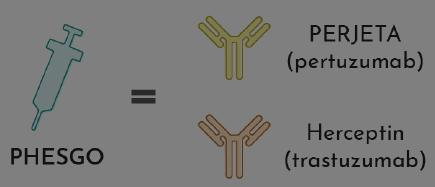

In [24]:
display.display(display.Image(base64.b64decode(relevant_images[0])))